# Import and misc

colab setup

In [66]:
# !pip install wandb
# !pip install thop
# !wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz -O speech_commands_v0.01.tar.gz
# !mkdir speech_commands && tar -C speech_commands -xvzf speech_commands_v0.01.tar.gz 1> log
# !mkdir student_model

In [ ]:
from typing import Tuple, Union, List, Callable, Optional
from tqdm import tqdm
from itertools import islice
import pathlib
import dataclasses

import numpy as np
import pandas as pd
import wandb
import thop
import random

import torch
import torch.nn.functional as F
from torch import nn
from torch import distributions
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence

import torchaudio
from IPython import display as display_

def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_random_seed(1337)

# Task

In this notebook we will implement a model for finding a keyword in a stream.

We will implement the version with CRNN because it is easy and improves the model. 
(from https://www.dropbox.com/s/22ah2ba7dug6pzw/KWS_Attention.pdf)

In [ ]:
@dataclasses.dataclass
class TaskConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 40
    n_mels: int = 40
    cnn_out_channels: int = 8
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    hidden_size: int = 64
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')

# Data

In [ ]:
class SpeechCommandDataset(Dataset):

    def __init__(
        self,
        transform: Optional[Callable] = None,
        path2dir: str = None,
        keywords: Union[str, List[str]] = None,
        csv: Optional[pd.DataFrame] = None
    ):
        self.transform = transform

        if csv is None:
            path2dir = pathlib.Path(path2dir)
            keywords = keywords if isinstance(keywords, list) else [keywords]
            
            all_keywords = [
                p.stem for p in path2dir.glob('*')
                if p.is_dir() and not p.stem.startswith('_')
            ]

            triplets = []
            for keyword in all_keywords:
                paths = (path2dir / keyword).rglob('*.wav')
                if keyword in keywords:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 1))
                else:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 0))
            
            self.csv = pd.DataFrame(
                triplets,
                columns=['path', 'keyword', 'label']
            )

        else:
            self.csv = csv
    
    def __getitem__(self, index: int):
        instance = self.csv.iloc[index]

        path2wav = instance['path']
        wav, sr = torchaudio.load(path2wav)
        wav = wav.sum(dim=0)
        
        if self.transform:
            wav = self.transform(wav)

        return {
            'wav': wav,
            'keywors': instance['keyword'],
            'label': instance['label']
        }

    def __len__(self):
        return len(self.csv)

In [ ]:
dataset = SpeechCommandDataset(
    path2dir='speech_commands', keywords=TaskConfig.keyword
)

In [ ]:
dataset.csv.sample(5)

,path,keyword,label
22653,speech_commands/one/b544d4fd_nohash_0.wav,one,0
41,speech_commands/happy/6d0ad764_nohash_3.wav,happy,0
51596,speech_commands/up/43fc47a7_nohash_1.wav,up,0
24053,speech_commands/three/11099149_nohash_0.wav,three,0
29690,speech_commands/nine/16d41d07_nohash_0.wav,nine,0


### Augmentations

In [ ]:
class AugsCreation:

    def __init__(self):
        self.background_noises = [
            'speech_commands/_background_noise_/white_noise.wav',
            'speech_commands/_background_noise_/dude_miaowing.wav',
            'speech_commands/_background_noise_/doing_the_dishes.wav',
            'speech_commands/_background_noise_/exercise_bike.wav',
            'speech_commands/_background_noise_/pink_noise.wav',
            'speech_commands/_background_noise_/running_tap.wav'
        ]

        self.noises = [
            torchaudio.load(p)[0].squeeze()
            for p in self.background_noises
        ]

    def add_rand_noise(self, audio):

        # randomly choose noise
        noise_num = torch.randint(low=0, high=len(
            self.background_noises), size=(1,)).item()
        noise = self.noises[noise_num]

        noise_level = torch.Tensor([1])  # [0, 40]

        noise_energy = torch.norm(noise)
        audio_energy = torch.norm(audio)
        alpha = (audio_energy / noise_energy) * \
            torch.pow(10, -noise_level / 20)

        start = torch.randint(
            low=0,
            high=max(int(noise.size(0) - audio.size(0) - 1), 1),
            size=(1,)
        ).item()
        noise_sample = noise[start: start + audio.size(0)]

        audio_new = audio + alpha * noise_sample
        audio_new.clamp_(-1, 1)
        return audio_new

    def __call__(self, wav):
        aug_num = torch.randint(low=0, high=4, size=(1,)).item()   # choose 1 random aug from augs
        augs = [
            lambda x: x,
            lambda x: (x + distributions.Normal(0, 0.01).sample(x.size())).clamp_(-1, 1),
            lambda x: torchaudio.transforms.Vol(.25)(x),
            lambda x: self.add_rand_noise(x)
        ]

        return augs[aug_num](wav)

In [ ]:
indexes = torch.randperm(len(dataset))
train_indexes = indexes[:int(len(dataset) * 0.8)]
val_indexes = indexes[int(len(dataset) * 0.8):]

train_df = dataset.csv.iloc[train_indexes].reset_index(drop=True)
val_df = dataset.csv.iloc[val_indexes].reset_index(drop=True)

# Sample is a dict of utt, word and label
train_set = SpeechCommandDataset(csv=train_df, transform=AugsCreation())
val_set = SpeechCommandDataset(csv=val_df)

### Sampler for oversampling:

In [ ]:
# We should provide to WeightedRandomSampler _weight for every sample_; by default it is 1/len(target)

def get_sampler(target):
    class_sample_count = np.array(
        [len(np.where(target == t)[0]) for t in np.unique(target)])   # for every class count it's number of occ.
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in target])
    samples_weight = torch.from_numpy(samples_weight)
    samples_weigth = samples_weight.float()
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    return sampler

In [ ]:
train_sampler = get_sampler(train_set.csv['label'].values)

In [ ]:
class Collator:
    
    def __call__(self, data):
        wavs = []
        labels = []    

        for el in data:
            wavs.append(el['wav'])
            labels.append(el['label'])

        # torch.nn.utils.rnn.pad_sequence takes list(Tensors) and returns padded (with 0.0) Tensor
        wavs = pad_sequence(wavs, batch_first=True)    
        labels = torch.Tensor(labels).long()
        return wavs, labels

###  Dataloaders

In [ ]:
# Here we are obliged to use shuffle=False because of our sampler with randomness inside.

train_loader = DataLoader(train_set, batch_size=TaskConfig.batch_size,
                          shuffle=False, collate_fn=Collator(),
                          sampler=train_sampler,
                          num_workers=2, pin_memory=True)

val_loader = DataLoader(val_set, batch_size=TaskConfig.batch_size,
                        shuffle=False, collate_fn=Collator(),
                        num_workers=2, pin_memory=True)

batch, label = next(iter(train_loader))
del batch, label

### Creating MelSpecs on GPU for speeeed: 

In [ ]:
class LogMelspec:

    def __init__(self, is_train, config):
        # with augmentations
        if is_train:
            self.melspec = nn.Sequential(
                torchaudio.transforms.MelSpectrogram(
                    sample_rate=config.sample_rate,
                    n_fft=400,
                    win_length=400,
                    hop_length=160,
                    n_mels=config.n_mels
                ),
                torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
                torchaudio.transforms.TimeMasking(time_mask_param=35),
            ).to(config.device)

        # no augmentations
        else:
            self.melspec = torchaudio.transforms.MelSpectrogram(
                sample_rate=config.sample_rate,
                n_fft=400,
                win_length=400,
                hop_length=160,
                n_mels=config.n_mels
            ).to(config.device)

    def __call__(self, batch):
        # already on device
        return torch.log(self.melspec(batch).clamp_(min=1e-9, max=1e9))

In [ ]:
melspec_train = LogMelspec(is_train=True, config=TaskConfig)
melspec_val = LogMelspec(is_train=False, config=TaskConfig)

### Quality measurment functions:

In [ ]:
# FA - true: 0, model: 1
# FR - true: 1, model: 0

def count_FA_FR(preds, labels):
    FA = torch.sum(preds[labels == 0])
    FR = torch.sum(labels[preds == 0])
    
    # torch.numel - returns total number of elements in tensor
    return FA.item() / torch.numel(preds), FR.item() / torch.numel(preds)

In [ ]:
def get_au_fa_fr(probs, labels):
    sorted_probs, _ = torch.sort(probs)
    sorted_probs = torch.cat((torch.Tensor([0]), sorted_probs, torch.Tensor([1])))
    labels = torch.cat(labels, dim=0)
        
    FAs, FRs = [], []
    for prob in sorted_probs:
        preds = (probs >= prob) * 1
        FA, FR = count_FA_FR(preds, labels)        
        FAs.append(FA)
        FRs.append(FR)
    # plt.plot(FAs, FRs)
    # plt.show()

    # ~ area under curve using trapezoidal rule
    return -np.trapz(FRs, x=FAs)

# Model

In [ ]:
class Attention(nn.Module):

    def __init__(self, hidden_size: int):
        super().__init__()

        self.energy = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, input):
        energy = self.energy(input)
        alpha = torch.softmax(energy, dim=-2)
        return (input * alpha).sum(dim=-2)

class CRNN(nn.Module):

    def __init__(self, config: TaskConfig):
        super().__init__()
        self.config = config

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        
        self.gru = nn.GRU(
            input_size=self.conv_out_frequency * config.cnn_out_channels,
            hidden_size=config.hidden_size,
            num_layers=config.gru_num_layers,
            dropout=0.1,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        self.attention = Attention(config.hidden_size)
        self.classifier = nn.Linear(config.hidden_size, config.num_classes)
    
    def forward(self, input):
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        contex_vector = self.attention(gru_output)
        output = self.classifier(contex_vector)
        return output

config = TaskConfig()
model = CRNN(config)
model

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)

# Training

In [ ]:
def train_epoch(model, opt, loader, log_melspec, device):
    model.train()
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        # run model # with autocast():
        logits = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(logits, dim=-1)
        loss = F.cross_entropy(logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc

In [ ]:
@torch.no_grad()
def validation(model, loader, log_melspec, device, record=False):
    model.eval()

    val_losses, accs, FAs, FRs = [], [], [], []
    all_probs, all_labels = [], []
    for i, (batch, labels) in tqdm(enumerate(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        output = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(output, dim=-1)
        loss = F.cross_entropy(output, labels)

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        all_probs.append(probs[:, 1].cpu())
        all_labels.append(labels.cpu())
        val_losses.append(loss.item())
        accs.append(
            torch.sum(argmax_probs == labels).item() /  # ???
            torch.numel(argmax_probs)
        )
        FA, FR = count_FA_FR(argmax_probs, labels)
        FAs.append(FA)
        FRs.append(FR)

    # area under FA/FR curve for whole loader
    au_fa_fr = get_au_fa_fr(torch.cat(all_probs, dim=0).cpu(), all_labels)

    if record:
        wandb.log({
            "au_fa_fr": au_fa_fr,
            "mean_acc": np.mean(accs),
            "mean_loss": np.mean(val_losses)
        })
    return au_fa_fr

In [ ]:
from collections import defaultdict
from IPython.display import clear_output
from matplotlib import pyplot as plt

history = defaultdict(list)

# Training

In [ ]:
config = TaskConfig(hidden_size=32)
model = CRNN(config).to(config.device)

print(model)

opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 32, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=32, out_features=2, bias=True)
)


In [ ]:
sum([p.numel() for p in model.parameters()])

25387

In [ ]:
# TRAIN
def train(record=False):
    if record:
        wandb.login(key='ecbb7f54f997fbf05d9983bfc9847256eea55632')
        wandb.init(
            project="HSE_DLA_KWS",
            config=config
            )
    for n in range(TaskConfig.num_epochs):

        train_epoch(model, opt, train_loader,
                    melspec_train, config.device)

        au_fa_fr = validation(model, val_loader,
                            melspec_val, config.device, record)
        
        torch.save({
            'model_state_dict': model.state_dict(),
        }, f'base_model_{n}_epoch.pth')
        history['val_metric'].append(au_fa_fr)

        clear_output()
        plt.plot(history['val_metric'])
        plt.ylabel('Metric')
        plt.xlabel('Epoch')
        plt.grid()
        plt.show()

        print('END OF EPOCH', n)

    wandb.finish()

In [ ]:
train(record=True)

In [ ]:
min(history['val_metric']), np.argmin(history['val_metric'])

(2.4550490748734768e-05, 36)

Luckily trained model

# Streaming

Let's create Streaming Class from our model

In [ ]:
class StreamingCRNN:
    def __init__(self, model, config, window_size=60):
        self.model = model
        self.config = config
        self.window_size = window_size

        self.buffer = torch.tensor([], device=config.device)
        self.gru_buffer = torch.tensor([], device=config.device)
        self.probas = torch.tensor([], device=config.device)
        self.hidden = torch.randn((self.config.gru_num_layers, 1, self.config.hidden_size),
                                  device=config.device)
    
    @torch.no_grad()
    def inference(self, x):
        x = x.unsqueeze(dim=1)
        self.buffer = torch.cat((self.buffer, x), dim=-1)
        if self.config.kernel_size[1] > self.buffer.shape[-1]:
            return
            
        self.buffer = self.buffer[:, :, :, -self.config.kernel_size[1]:]  
        conv_output = self.model.conv(self.buffer).transpose(-1, -2)
        
        gru_output, hidden = self.model.gru(conv_output, self.hidden)
        self.hidden = hidden
        
        self.gru_buffer = torch.cat((self.gru_buffer, gru_output), dim=1)
        # print(self.gru_buffer.shape)
        if self.gru_buffer.shape[1] > self.window_size:
            # print(self.gru_buffer.shape)
            self.gru_buffer = self.gru_buffer[:, 1:, ]
            # print(self.gru_buffer.shape)

        contex_vector = self.model.attention(self.gru_buffer)
        proba = self.model.classifier(contex_vector)
        proba = F.softmax(proba, dim=-1)[0][1].unsqueeze(0)
        print(proba)
        self.probas = torch.cat((self.probas, proba))

In [ ]:
final_sample = torch.tensor([], device=TaskConfig.device)
row_audio = torch.tensor([], device=TaskConfig.device)
labels = []

for i in range(95, 105):
    sample = val_set[i]
    sample, label = Collator()([sample])
    row_audio = torch.cat((row_audio, sample.to(TaskConfig.device)), dim=-1)
    labels += [label.item()]
    sample = melspec_val(sample.to(TaskConfig.device))
    final_sample = torch.cat((final_sample, sample), dim=-1)

display_.display(display_.Audio(row_audio.cpu(), rate=TaskConfig.sample_rate, normalize=False))
labels

[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]

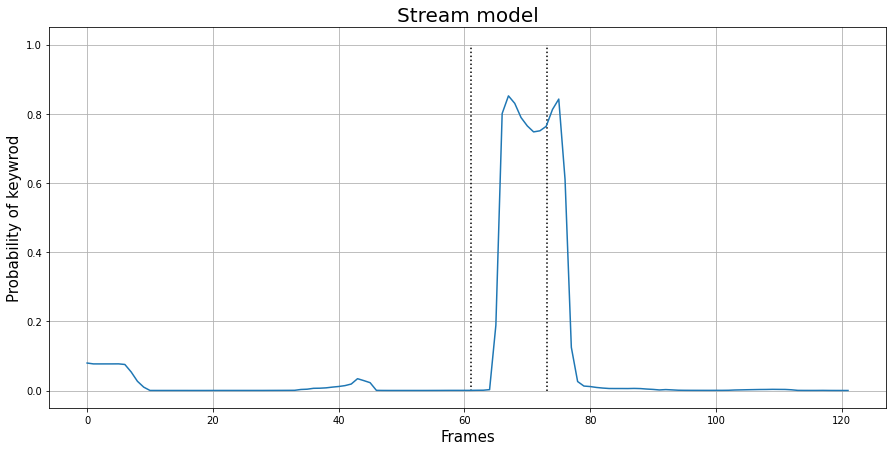

In [ ]:
window_size = 10
StreamModel = StreamingCRNN(model, config, window_size=window_size)

step = 8
for i in range(0, final_sample.shape[2], step):
    StreamModel.inference(final_sample[:, :, i:i+step])

plt.figure(figsize=(15, 7))
plt.plot(StreamModel.probas.cpu().numpy())
window_size = (StreamModel.probas.shape[0] / len(labels))
plt.vlines([labels.index(1) * window_size, (labels.index(1) + 1) * window_size],
           ymin=0, ymax=1, linestyles='dotted')
plt.title('Stream model', size=20)
plt.ylabel('Probability of keywrod', size=15)
plt.xlabel('Frames', size=15)
plt.grid()
plt.show()

In [ ]:
class CRNN(nn.Module):

    def __init__(self, config: TaskConfig):
        super().__init__()
        # self.config = config

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        
        self.gru = nn.GRU(
            input_size=self.conv_out_frequency * config.cnn_out_channels,
            hidden_size=config.hidden_size,
            num_layers=config.gru_num_layers,
            dropout=0.1,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        self.attention = Attention(config.hidden_size)
        self.classifier = nn.Linear(config.hidden_size, config.num_classes)
    
    def forward(self, input):
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        contex_vector = self.attention(gru_output)
        output = self.classifier(contex_vector)
        return output

In [ ]:
class StreamingCRNN(nn.Module):
    def __init__(self, model, config: TaskConfig, max_window_length=60):
        super().__init__()
        self.model = model
        self.kernel_size = config.kernel_size[1]
        self.max_window_length = max_window_length

        self.buffer = torch.tensor([], device=config.device)
        self.gru_buffer = torch.tensor([], device=config.device)
        self.hidden = torch.randn((config.gru_num_layers, 1, config.hidden_size),
                                  device=config.device)
        
        self.melspec = torchaudio.transforms.MelSpectrogram(
            sample_rate=config.sample_rate,
            n_fft=400,
            win_length=400,
            hop_length=160,
            n_mels=config.n_mels
        ).to(config.device)

        self.softmax = torch.nn.Softmax(dim=-1)
    
    @torch.no_grad()
    def forward(self, x):
        x = torch.log(self.melspec(x).clamp_(min=1e-9, max=1e9))
        x = x.unsqueeze(dim=1)

        self.buffer = torch.cat((self.buffer, x), dim=-1)
        if self.kernel_size > self.buffer.shape[-1]:
            return
            
        self.buffer = self.buffer[:, :, :, -self.kernel_size:]
        conv_output = self.model.conv(self.buffer).transpose(-1, -2)
        
        gru_output, hidden = self.model.gru(conv_output, self.hidden)
        self.hidden = hidden

        
        self.gru_buffer = torch.cat((self.gru_buffer, gru_output), dim=1)
        if self.gru_buffer.shape[1] > self.max_window_length:
            self.gru_buffer = self.gru_buffer[:, 1:, ]

        contex_vector = self.model.attention(self.gru_buffer)
        proba = self.model.classifier(contex_vector)
        return self.softmax(proba)[0][1]

In [ ]:
batch, labels = next(iter(val_loader))
step = 1000
for elem, label in zip(batch[-15:-5, :], labels[-15:-5]):
    print('\n', label)
    for i in range(0, elem.shape[0], step):
        x = elem[i:i+step].unsqueeze(dim=0).to(config.device)
        print(StreamModel(x))

In [ ]:
model2 = CRNN(config).to(config.device)
model2.load_state_dict(torch.load('base_model_39_epoch.pth')['model_state_dict'])
max_window_length = 60
StreamModel = StreamingCRNN(model2, config, max_window_length=max_window_length).to(config.device)
m = torch.jit.script(StreamModel)
m.save("kws.pth")

# Time and Memory

In [67]:
from thop import profile, clever_format
import tempfile
import time
import os


class Timer:
    def __init__(self, name: str, verbose=False):
        self.name = name
        self.verbose = verbose

    def __enter__(self):
        self.t = time.time()
        return self

    def __exit__(self, type, value, traceback):
        self.t = time.time() - self.t
        if self.verbose:
            print(f"{self.name.capitalize()} | Elapsed time : {self.t:.2f}")

def get_size_in_megabytes(model):
    # https://pytorch.org/tutorials/recipes/recipes/dynamic_quantization.html#look-at-model-size
    with tempfile.TemporaryFile() as f:
        torch.save(model.state_dict(), f)
        size = f.tell() / 2**20
    return size

def time_and_memory(model, batch, device, name):
    print(f'REPORT FOR {name} model')
    print('------------------------')
    model = model.to(device)
    # m = torch.jit.script(model)
    # m.save('del.pth')
    torch.save(model.state_dict(), 'del.p')
    real_size = os.path.getsize('del.p')
    os.remove('del.p')
    batch = batch.to(device)
    macs, params = profile(model, (batch, )) 
    macs, params = clever_format([macs, params], "%.3f")
    size = get_size_in_megabytes(model)
    with Timer('time') as t:
        au_fa_fr = validation(model, val_loader, melsp, device)
    
    x = torch.randn(1, 2 * 16000)
    x = melsp(x)
    with Timer('time') as t_one:
        with torch.no_grad():
            model(x)

    with torch.no_grad():
        with Timer('time') as t_two:
            for i in range(10):
                model(x)
    
    print('------------------------')
    print('AU_FA_FR =', au_fa_fr)
    print('Time on validation = {:.2f}'.format(t.t))
    print('Time on 2 sec audio = {}'.format(t_one.t))
    print('Time on 10x2 sec audios = {}'.format(t_two.t))
    print('MACs =', macs)
    print('Params =', params)
    print(f'Model size = {size} mb')
    print(f'Real moddel size = {real_size / 1000} kb')
    print('------------------------')
    return au_fa_fr, t.t, t_one.t, t_two.t, macs, params, size, real_size

In [ ]:
device = 'cpu'
config = TaskConfig(hidden_size=32, device=device)
base_model = CRNN(config).to(device)
base_model.load_state_dict(torch.load('base_model_32_epoch.pth')['model_state_dict'])
batch, _ = next(iter(val_loader))
batch.to(device)
melsp = LogMelspec(is_train=False, config=config)
batch = melsp(batch)

In [ ]:
(base_au_fa_fr,
 base_val_time,
 base_2sec_time,
 base_20sec_time,
 base_macs,
 base_params,
 base_size,
 base_real_size) = time_and_memory(base_model, batch, device, 'base')

REPORT FOR base model
------------------------
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


102it [00:08, 12.19it/s]


------------------------
AU_FA_FR = 2.9610971097525987e-05
Time on validation = 12.17
Time on 2 sec audio = 0.001874685287475586
Time on 10x2 sec audios = 0.01439666748046875
MACs = 55.382M
Params = 25.387K
Model size = 0.10348224639892578 mb
Real moddel size = 106.037 kb
------------------------


# Distillation

Finally reached smth interesting :)))))))

In [ ]:
def train_distillation(teacher_model, student_model, name, config, record, temp=1, alpha=0.5, log_step=3, save_step=3):
    history = defaultdict(list)
    if record:
        wandb.login(key='ecbb7f54f997fbf05d9983bfc9847256eea55632')
        wandb.init(
            project="HSE_DLA_KWS",
            config=config
            )
    for n in range(config.num_epochs):

        train_epoch_distillation(teacher_model, student_model, opt, train_loader, 
                                 melspec_train, config.device, temp, alpha)

        if n % log_step == 0:
            au_fa_fr = validation(student_model, val_loader,
                                melspec_val, config.device, record)
            history['val_metric'].append(au_fa_fr)
        if n > 10 and n % save_step == 0:
            torch.save({
                'model_state_dict': student_model.state_dict(),
            }, f'student_model/{name}_{n}_epoch.pth')

        clear_output()
        plt.plot(history['val_metric'])
        plt.ylabel('Metric')
        plt.xlabel('Epoch')
        plt.grid()
        plt.show()

        print('END OF EPOCH', n)

    wandb.finish()

def train_epoch_distillation(teacher_model, student_model, opt, loader, log_melspec, device, temp=1, alpha=0.5):
    teacher_model.eval()
    student_model.train()
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        logits = student_model(batch)
        probs = F.softmax(logits, dim=-1)

        with torch.no_grad():
            teacher_logits = teacher_model(batch) / temp
        teacher_probs = F.softmax(teacher_logits, dim=-1)
        
        loss_teacher = -(teacher_probs*probs).sum(dim=1).mean()
        loss_casual = F.cross_entropy(logits, labels)
        loss = alpha * loss_teacher + (1 - alpha) * loss_casual

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc

In [ ]:
teacher_config = TaskConfig(hidden_size=32)
teacher_model = CRNN(teacher_config).to(teacher_config.device)
teacher_model.load_state_dict(torch.load('base_model_32_epoch.pth')['model_state_dict'])
print('\nTeacher config:\n', teacher_config)
print('\nTeacher\n', teacher_model)

student_config = TaskConfig(
    cnn_out_channels = 2,
    stride = (2, 6),
    hidden_size = 16,
    gru_num_layers = 1,
    num_epochs=80
)
student_model = CRNN(student_config).to(student_config.device)
print('\nStudent config:\n', student_config)
print('\nStudent\n', student_model)
print()

opt = torch.optim.Adam(
    student_model.parameters(),
    lr=student_config.learning_rate,
    weight_decay=student_config.weight_decay
)

student_model_copy = CRNN(student_config)
time_and_memory(student_model_copy, batch, device, 'student1')
del student_model_copy


Teacher config:
 TaskConfig(keyword='sheila', batch_size=128, learning_rate=0.0003, weight_decay=1e-05, num_epochs=40, n_mels=40, cnn_out_channels=8, kernel_size=(5, 20), stride=(2, 8), hidden_size=32, gru_num_layers=2, bidirectional=False, num_classes=2, sample_rate=16000, device=device(type='cuda', index=0))

Teacher
 CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 32, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=32, out_features=2, bias=True)
)

Student config:
 TaskConfig(keyword='sheila', batch_size=128, learning_rate=0.0003, weight_decay=1e-05, num_epochs=80, n_mels=40, cnn_out_channels=2, kernel_size=(5, 20), stride=(2, 6), hidden_size=16, gru_n

102it [00:09, 10.43it/s]


------------------------
AU_FA_FR = 0.017884662522503248
Time on validation = 13.67
Time on 2 sec audio = 0.001537322998046875
Time on 10x2 sec audios = 0.010305643081665039
MACs = 11.788M
Params = 3.117K
Model size = 0.017495155334472656 mb
Real moddel size = 16.001 kb
------------------------


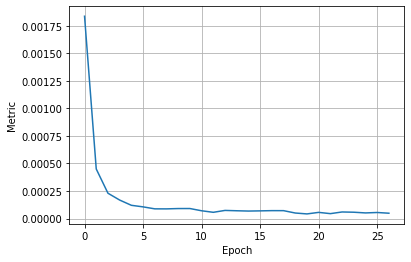

END OF EPOCH 79


au_fa_fr,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_acc,▁▃▆▆▇▇▇█▇██▇███████████████
mean_loss,█▆▃▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
au_fa_fr,5e-05
mean_acc,0.98058
mean_loss,0.05496


In [ ]:
train_distillation(teacher_model, student_model, 'best', student_config, record=True,
                   temp=3, alpha=0.7, log_step=3, save_step=3)

In [ ]:
def compress(au_fa_fr, val_time, sec2_time, sec20_time, macs, params, size, real_size):
    # assert au_fa_fr <= 5e-5 * 1.1
    print('We compressed base model')
    print('by time:')
    print('for val time in {:.3f} times'.format(base_val_time / val_time))
    print('for 2 sec time in {:.3f} times'.format(base_2sec_time / sec2_time))
    print('for 10x2 sec time in {:.3f} times\n'.format(base_20sec_time / sec20_time))
    print('by memory:')
    print('macs in {:.3f} times'.format(float(base_macs[:-1]) / float(macs[:-1])))
    if params[-1] == 'B':
        print('params in {:.3f} times'.format(float(base_params[:-1]) * 1000 / float(params[:-1])))
    else:
        print('params in {:.3f} times'.format(float(base_params[:-1]) / float(params[:-1])))
    print('size in {:.3f} times'.format(base_size / size))
    print('real size in {:.3f} times'.format(base_real_size / real_size))

In [ ]:
from IPython.display import clear_output

(student1_au_fa_fr,
 student1_val_time,
 student1_2sec_time,
 student1_20sec_time,
 student1_macs,
 student1_params,
 student1_size,
 student1_real_size) = time_and_memory(student_model, batch, device, 'student1')

clear_output()

compress(student1_au_fa_fr,
 student1_val_time,
 student1_2sec_time,
 student1_20sec_time,
 student1_macs,
 student1_params,
 student1_size,
 student1_real_size)

We compressed base model
by time:
for val time in 1.052 times
for 2 sec time in 1.370 times
for 10x2 sec time in 1.417 times

by memory:
macs in 4.698 times
params in 8.145 times
size in 5.915 times
real size in 6.627 times


At least smth

# Quantization

**Base model**

In [ ]:
config = TaskConfig(hidden_size=32, device='cpu')
model = CRNN(config).to(config.device)
model.load_state_dict(torch.load('base_model_32_epoch.pth')['model_state_dict'])
quantized_model = torch.quantization.quantize_dynamic(model, dtype=torch.qint8)

(quantized_au_fa_fr,
 quantized_val_time,
 quantized_2sec_time,
 quantized_20sec_time,
 quantized_macs,
 quantized_params,
 quantized_size,
 quantized_real_size) = time_and_memory(quantized_model, batch, device, 'Quantized base')

compress(quantized_au_fa_fr,
 quantized_val_time,
 quantized_2sec_time,
 quantized_20sec_time,
 quantized_macs,
 quantized_params,
 quantized_size,
 quantized_real_size)

REPORT FOR Quantized base model
------------------------
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.


102it [00:09, 11.14it/s]


------------------------
AU_FA_FR = 3.0321109259679473e-05
Time on validation = 12.94
Time on 2 sec audio = 0.002663135528564453
Time on 10x2 sec audios = 0.020047426223754883
MACs = 20.275M
Params = 808.000B
Model size = 0.043166160583496094 mb
Real moddel size = 36.387 kb
------------------------
We compressed base model
by time:
for val time in 0.940 times
for 2 sec time in 0.704 times
for 10x2 sec time in 0.718 times

by memory:
macs in 2.732 times
params in 31.420 times
size in 2.397 times
real size in 2.914 times


**Distilled model**

In [68]:
quantized_student_model = student_model.to('cpu')
quantized_student_model = torch.quantization.quantize_dynamic(quantized_student_model, dtype=torch.qint8)

(quantized_st_au_fa_fr,
 quantized_st_val_time,
 quantized_st_2sec_time,
 quantized_st_20sec_time,
 quantized_st_macs,
 quantized_st_params,
 quantized_st_size,
 quantized_st_real_size) = time_and_memory(quantized_student_model, batch, device, 'Quantized student')

compress(quantized_st_au_fa_fr,
 quantized_st_val_time,
 quantized_st_2sec_time,
 quantized_st_20sec_time,
 quantized_st_macs,
 quantized_st_params,
 quantized_st_size,
 quantized_st_real_size)

REPORT FOR Quantized student model
------------------------
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.


/usr/local/lib/python3.7/dist-packages/torch/nn/quantized/dynamic/modules/rnn.py:85: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
102it [00:09, 10.42it/s]


------------------------
AU_FA_FR = 4.748574594054755e-05
Time on validation = 13.79
Time on 2 sec audio = 0.003549814224243164
Time on 10x2 sec audios = 0.01902914047241211
MACs = 6.451M
Params = 202.000B
Model size = 0.017304420471191406 mb
Real moddel size = 12.439 kb
------------------------
We compressed base model
by time:
for val time in 0.882 times
for 2 sec time in 0.528 times
for 10x2 sec time in 0.757 times

by memory:
macs in 8.585 times
params in 125.678 times
size in 5.980 times
real size in 10.095 times
